In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
r = 0.01
sigma = 0.2
X_0 = 100
T = 1.0

sigma = 0.2
N = 1000
dt = T/N

S0 = 100
K = 100
v0 = 0.04
lambd = 2.0
v_ = 0.04
eta = 0.2
rho = -0.5

N_Heston = 100
I = 10000

option_price = 10

np.random.seed(42)

In [3]:
def black_scholes_call(S, X, T, r, sigma):
    d1 = (np.log(S / X) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call_price = S * stats.norm.cdf(d1) - X * np.exp(-r * T) * stats.norm.cdf(d2)

    return call_price

# 1. Discrétiser l’EDS de Black & Scholes avec un schéma d’Euler et un schéma de Milstein. Illustrer les convergences et retrouver les ordres forts et faibles de chacun des schémas.

In [4]:
def a(x):
    return r * x

def b(x):
    return sigma * x

def simulate_paths(N, dt):
    X_euler = np.zeros(N+1)
    X_milstein = np.zeros(N+1)
    X_bs = np.zeros(N+1)
    X_euler[0] = X_0
    X_milstein[0] = X_0
    X_bs[0] = X_0

    for i in range(1, N+1):
        dW = np.sqrt(dt) * np.random.normal()

        # Euler method
        X_euler[i] = X_euler[i-1] + a(X_euler[i-1]) * dt + b(X_euler[i-1]) * dW

        # Milstein method
        X_milstein[i] = X_milstein[i-1] + a(X_milstein[i-1]) * dt \
                        + b(X_milstein[i-1]) * dW \
                        + 0.5 * b(X_milstein[i-1]) * sigma * (dW**2 - dt)

        X_bs[i] = X_bs[i-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * dW)

    return X_euler, X_milstein, X_bs

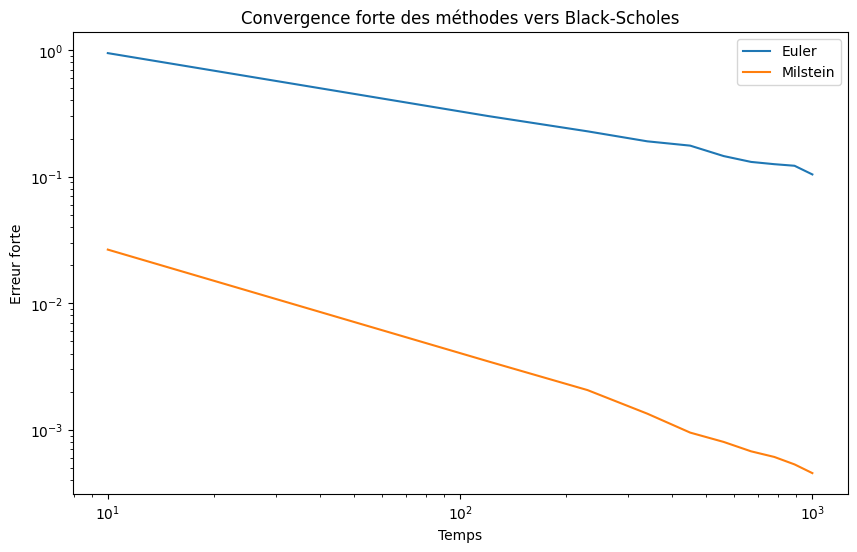

In [5]:
num_paths = 100
num_steps_values = np.linspace(10, 1000, 10)

plt.figure(figsize=(10, 6))

strong_error_euler = np.zeros(len(num_steps_values))
strong_euler_milstein = np.zeros(len(num_steps_values))

for i, num_steps in enumerate(num_steps_values):
  for j in range(num_paths):
      dt = T / int(num_steps)
      X_euler, X_milstein, X_bs = simulate_paths(int(num_steps), dt)

      strong_error_euler[i] += np.max(np.abs(X_euler-X_bs))
      strong_euler_milstein[i] += np.max(np.abs(X_milstein-X_bs))

  strong_error_euler[i] /= num_paths
  strong_euler_milstein[i] /= num_paths

plt.plot(num_steps_values, strong_error_euler, label=f'Euler')
plt.plot(num_steps_values, strong_euler_milstein, label=f'Milstein')

plt.title('Convergence forte des méthodes vers Black-Scholes')
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Temps')
plt.ylabel('Erreur forte')
plt.legend()
plt.show()

In [6]:
def fit_line(x, y):
    coeffs = np.polyfit(np.log(x), np.log(y), 1)
    return coeffs[0]

order_euler = fit_line(num_steps_values, strong_error_euler)
order_milstein = fit_line(num_steps_values, strong_euler_milstein)

print(f"Ordre de convergence pratique pour Euler : {-order_euler}")
print(f"Ordre de convergence théorique pour Euler : 0.5")
print(f"Ordre de convergence pratique pour Milstein : {-order_milstein}")
print(f"Ordre de convergence théorique pour Milstein : 1")

Ordre de convergence pratique pour Euler : 0.4673773486764629
Ordre de convergence théorique pour Euler : 0.5
Ordre de convergence pratique pour Milstein : 0.8844110470846147
Ordre de convergence théorique pour Milstein : 1


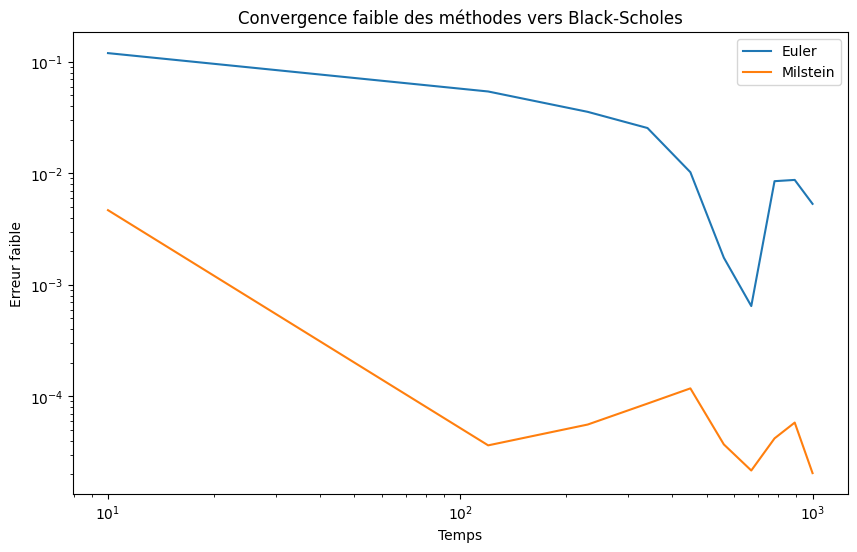

In [7]:
def f(x):
  return x

plt.figure(figsize=(10, 6))

weak_error_euler = np.zeros(len(num_steps_values))
weak_euler_milstein = np.zeros(len(num_steps_values))

euler_f = np.zeros(len(num_steps_values))
milstein_f = np.zeros(len(num_steps_values))
bs_f = np.zeros(len(num_steps_values))

for i, num_steps in enumerate(num_steps_values):
  num_steps=int(num_steps)
  euler_f = 0
  milstein_f = 0
  bs_f = 0
  for j in range(num_paths):
      dt = T / num_steps
      X_euler, X_milstein, X_bs = simulate_paths(num_steps, dt)

      euler_f += f(X_euler[-1])
      milstein_f += f(X_milstein[-1])
      bs_f += f(X_bs[-1])

  euler_f /= num_paths
  milstein_f /= num_paths
  bs_f /= num_paths

  weak_error_euler[i] += np.abs(euler_f-bs_f)
  weak_euler_milstein[i] += np.abs(milstein_f-bs_f)

plt.plot(num_steps_values, weak_error_euler, label=f'Euler')
plt.plot(num_steps_values, weak_euler_milstein, label=f'Milstein')

plt.title('Convergence faible des méthodes vers Black-Scholes')
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Temps')
plt.ylabel('Erreur faible')
plt.legend()
plt.show()

In [8]:
order_euler = fit_line(num_steps_values, weak_error_euler)
order_milstein = fit_line(num_steps_values, weak_euler_milstein)

print(f"Ordre de convergence pratique pour Euler : {-order_euler}")
print(f"Ordre de convergence théorique pour Euler : 1")
print(f"Ordre de convergence pratique pour Milstein : {-order_milstein}")
print(f"Ordre de convergence théorique pour Milstein : 1")

Ordre de convergence pratique pour Euler : 0.8499645860971503
Ordre de convergence théorique pour Euler : 1
Ordre de convergence pratique pour Milstein : 0.9840760604440217
Ordre de convergence théorique pour Milstein : 1


Nous retrouvons bien les ordres de convergence attendus.

# 2. Implémenter le pricing d’un call standard dans le modèle de Heston par Monte Carlo, avec le schéma d’Euler simple proposé.

In [9]:
def Heston(S0, K, T, r, v0, lambd, v_, eta, rho, N, I, IC=False):

    dt = T / N
    np.random.seed(0)

    S = np.zeros((N + 1, I))
    S[0] = np.log(S0)
    v = np.zeros_like(S)
    v[0] = v0

    for t in range(1, N + 1):
        b1 = np.random.standard_normal(I)
        b2 = np.random.standard_normal(I)
        dz1 = b1 * np.sqrt(dt)
        dz2 = (rho * b1 + np.sqrt(1 - rho ** 2) * b2) * np.sqrt(dt)

        # conditions réfléchissantes
        v[t] = np.maximum(v[t - 1] - lambd * (np.maximum(v[t - 1], 0) - v_) * dt + eta * np.sqrt(np.maximum(v[t - 1], 0)) * dz2, 0)
        S[t] = S[t - 1] + (r - 0.5 * v[t - 1]) * dt + np.sqrt(v[t - 1]) * dz1

    C0 = np.exp(-r * T) * np.mean(np.maximum(np.exp(S[-1]) - K, 0))

    if IC:
        std_error = np.std(np.exp(-r * T) * np.maximum(np.exp(S[-1]) - K, 0)) / np.sqrt(I)

        z = 1.96
        lower_bound = C0 - z * std_error
        upper_bound = C0 + z * std_error

        return C0, lower_bound, upper_bound

    return C0

print(Heston(S0, K, T, r, v0, lambd, v_, eta, rho, N_Heston, I, True))

(8.277131979080428, 8.037586606072908, 8.516677352087948)


# 3. Implémenter le calcul de la la volatilité implicite de Black & Scholes par dichotomie. On peut se ramener à un intervalle borné en écrivant Vt = x / (1-x), x ∈ [0, 1].

In [10]:
def implied_volatility(option_price, S, K, T, r, tol=1e-6, max_iter=1000):
    lower_volatility = 0.
    upper_volatility = 1.0

    iteration = 0
    while iteration < max_iter:
        mid_volatility = (lower_volatility + upper_volatility) / 2
        option_price_mid = black_scholes_call(S, K, T, r, mid_volatility)

        if np.abs(option_price_mid - option_price) < tol:
            return mid_volatility

        if option_price_mid < option_price:
            lower_volatility = mid_volatility
        else:
            upper_volatility = mid_volatility

        iteration += 1
    return mid_volatility

implied_vol = implied_volatility(option_price, S0, K, T, r)
print("Implied Volatility:", implied_vol)

Implied Volatility: 0.239749014377594


# 4. Tracer un exemple de smile de volatilité dans le modèle de Heston.

In [11]:
strikes = np.arange(50, 151, 5)
heston_prices = np.zeros(len(strikes))
implied_vols = np.zeros(len(strikes))

v0 = 0.04
lambd = 2.0
v_ = 0.04
eta = 0.2
rho = -0.5

for i, strike in enumerate(strikes):
  heston_prices[i] = Heston(S0, strike, T, r, v0, lambd, v_, eta, rho, N_Heston, I)
  implied_vols[i] = implied_volatility(heston_prices[i], S0, strike, T, r)

Text(0, 0.5, 'Volatilité implicite')

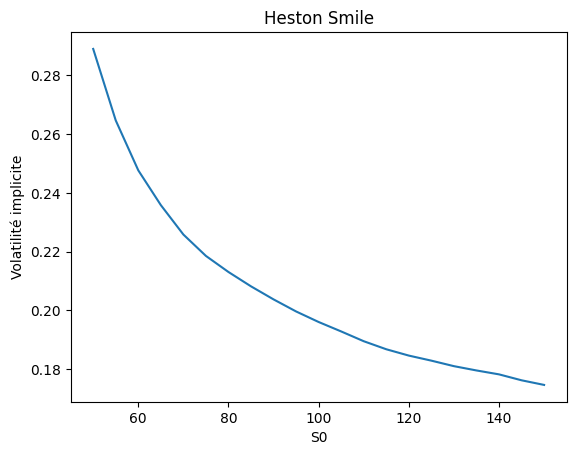

In [12]:
plt.plot(strikes, implied_vols)
plt.title("Heston Smile")
plt.xlabel("S0")
plt.ylabel("Volatilité implicite")

# 5. Montrer la déformation du smile/skew de volatilité en fonction des paramètres de la dynamique de volatilité λ, η et ρ.

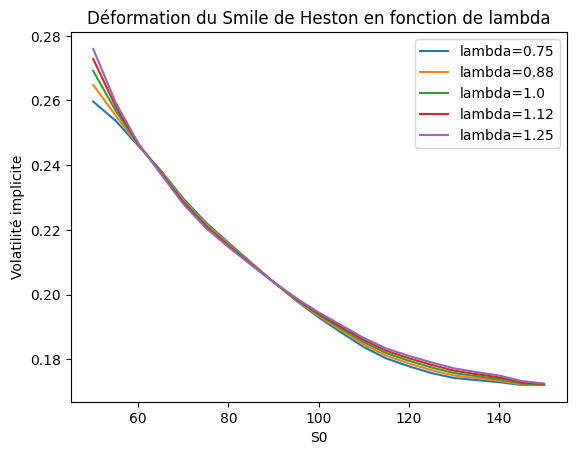

In [13]:
lambd_values = np.linspace(0.75, 1.25, 5)

for lambd_ in lambd_values:
  vol_values = np.zeros(len(strikes))
  for i, strike in enumerate(strikes):
    heston_price = Heston(S0, strike, T, r, v0, lambd_, v_, eta, rho, N_Heston, I)
    vol_values[i] = implied_volatility(heston_price, S0, strike, T, r, tol=1e-6, max_iter=1000)
  plt.plot(strikes, vol_values, label=f"lambda={np.round(lambd_,2)}")
plt.title("Déformation du Smile de Heston en fonction de lambda")
plt.xlabel("S0")
plt.ylabel("Volatilité implicite")
plt.legend()

La valeur de lambda semble impacter la convexité du smile de volatilité dans le modèle de Heston. Cela est tout à fait cohérent car le lambda représente la vitesse de retour à la moyenne du processus de variance.

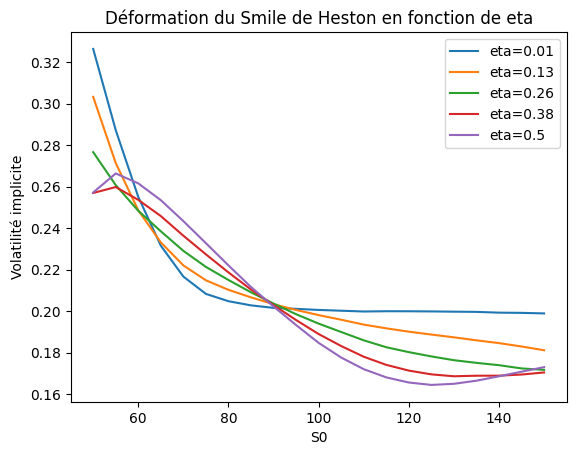

In [14]:
eta_values = np.linspace(0.01, 0.5, 5)

for eta_ in eta_values:
  vol_values = np.zeros(len(strikes))
  for i, strike in enumerate(strikes):
    heston_price = Heston(S0, strike, T, r, v0, lambd, v_, eta_, rho, N_Heston, I)
    vol_values[i] = implied_volatility(heston_price, S0, strike, T, r, tol=1e-6, max_iter=1000)
  plt.plot(strikes, vol_values, label=f"eta={round(eta_,2)}")
plt.title("Déformation du Smile de Heston en fonction de eta")
plt.xlabel("S0")
plt.ylabel("Volatilité implicite")
plt.legend()

La valeur de eta semble jouer un rôle sur la convexité mais plus spécifiquement sur la remontée skew. Avec un eta faible, cela ne permet pas la volailité implicte du modèle de Heston de remonter pour des strikes élevés.

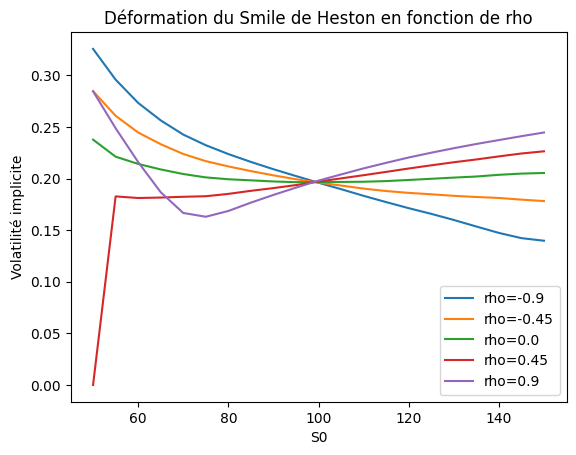

In [15]:
rho_values = np.linspace(-0.9, 0.9, 5)

for rho_ in rho_values:
  vol_values = np.zeros(len(strikes))
  for i, strike in enumerate(strikes):
    heston_price = Heston(S0, strike, T, r, v0, lambd, v_, eta, rho_, N_Heston, I)
    vol_values[i] = implied_volatility(heston_price, S0, strike, T, r, tol=1e-6, max_iter=1000)
  plt.plot(strikes, vol_values, label=f"rho={round(rho_,2)}")
plt.title("Déformation du Smile de Heston en fonction de rho")
plt.xlabel("S0")
plt.ylabel("Volatilité implicite")
plt.legend()

Rho étant le coefficient de corrélation entre les browniens associés aux deux processus, nous nous attendons à le voir jouer un rôle important sur le smile de Heston. En effet, nous remarquons qu'une corrélation très négative entraîne la formation d'un skew. Avec une corrélation nulle, il y a un faible smile centré en S0. Pour les corrélations positives, nous observons un important smile se former avec un minimum se trouvant pour une valeur inférieure à S0.